In [18]:
import pandas as pd
import matplotlib.pyplot as plt

year = 2023

data = pd.read_csv('data/' + str(year) + '.csv')
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

data = data[data['place'] <= 10]

data['points'] = 11 - data['place']
data["name"] = data["firstname"] + " " + data["lastname"]

In [19]:
from IPython.display import display

athletes_per_club = data.groupby('club')['athleteId'].nunique()
athletes_per_club = athletes_per_club.reset_index()
athletes_per_club.columns = ['Verein', 'Athleten']
athletes_per_club = athletes_per_club.sort_values(by='Athleten', ascending=False)

# Filtert Mannschafts und Staffel Ergebnisse heraus, welche nur einmal gewertet werden sollen
clubData = data.drop_duplicates(subset=['ageGroup', 'club', 'discipline', 'result', 'teamResult', 'place', 'location', 'date'])

# Punkte pro Verein aggregieren
clubData = clubData.groupby('club')['points'].sum().reset_index()
#agegroupPoints = data.drop_duplicates(subset=['ageGroup', 'club', 'discipline', 'result', 'teamResult', 'place', 'location', 'date'])
#agegroupPoints = agegroupPoints.groupby(['ageGroup', 'club'])['points'].sum().reset_index()

#print(agegroupPoints[agegroupPoints['club'] == 'LA Team Saar'])

# Vereine nach Punkten sortieren und Index zurücksetzen
clubData = clubData.sort_values(by='points', ascending=False)
clubData = clubData.reset_index(drop=True)
clubData = clubData.rename(columns={'points': 'Punkte'})
clubData.index += 1

combined_data = pd.merge(athletes_per_club, clubData, left_on='Verein', right_on='club', how='outer')
combined_data.drop(columns='club', inplace=True)
combined_data['Verhältnis Punkte/Athleten'] = round(combined_data['Punkte'] / combined_data['Athleten'], 2)
combined_data = combined_data.sort_values(by='Punkte', ascending=False)
combined_data.reset_index(drop=True, inplace=True)
combined_data.index += 1

display(combined_data)

,Verein,Athleten,Punkte,Verhältnis Punkte/Athleten
1,LC Rehlingen,154,3180,20.65
2,LA Team Saar,114,2224,19.51
3,SV GO! Saar 05,65,1569,24.14
4,LSG Sbr.-Sulzbachtal,70,1319,18.84
5,LG Saar 70,58,760,13.10
6,ATSV Saarbrücken,36,722,20.06
7,LG Berus,23,718,31.22
8,TV St. Wendel,19,564,29.68
9,LAC Saarlouis,26,539,20.73
10,LV Merzig,22,525,23.86


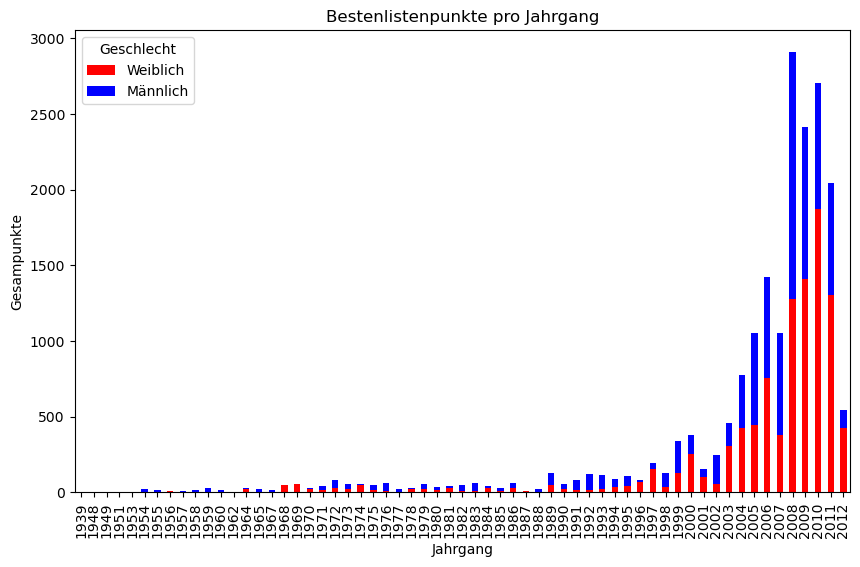

gender,Weiblich,Männlich
birthyear,,
2012,422,121
2011,1307,737
2010,1874,833
2009,1409,1003
2008,1277,1632
2007,380,673
2006,755,666
2005,447,606
2004,422,356


In [20]:


data['gender'] = data['ageGroup'].apply(lambda x: "Männlich" if 'M' in x else "Weiblich")
data['gender'] = pd.Categorical(data['gender'], categories=["Weiblich", "Männlich"])

# Punkte pro Jahrgang und Geschlecht aggregieren
birthYearData = data.groupby(['birthyear', 'gender'])['points'].sum().reset_index()
birthYearData = birthYearData[birthYearData['birthyear'] != 0]

pivot_data = birthYearData.pivot_table(index='birthyear', columns='gender', values='points', aggfunc='sum', fill_value=0)
colors = {'Männlich': 'blue', 'Weiblich': 'red'}
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in pivot_data.columns])
plt.title('Bestenlistenpunkte pro Jahrgang')
plt.xlabel('Jahrgang')
plt.ylabel('Gesampunkte')
plt.legend(title='Geschlecht', loc='upper left')
plt.show()

display(pivot_data.sort_values(by='birthyear', ascending=False).head(20))

## Anzahl Athleten pro Jahrgang in Bestenliste Top 10

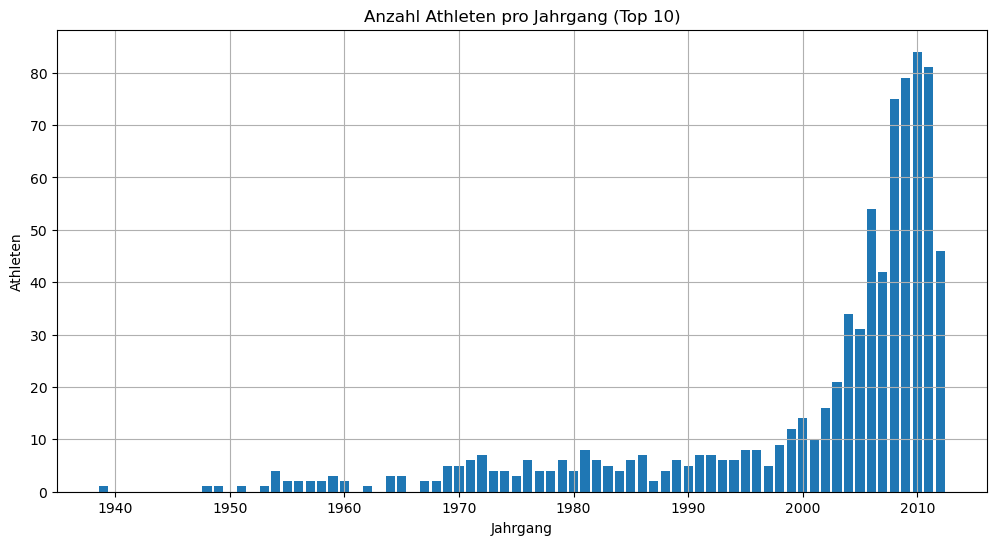

,Jahrgang,Athleten
1,2012,46
2,2011,81
3,2010,84
4,2009,79
5,2008,75
6,2007,42
7,2006,54
8,2005,31
9,2004,34
10,2003,21


In [21]:
## amount of athletes per birthyear
birthyear_counts = data[data['birthyear'] != 0]
birthyear_counts = birthyear_counts.drop_duplicates(subset=['name', 'birthyear'])
birthyear_counts = birthyear_counts['birthyear'].value_counts().reset_index()
birthyear_counts.columns = ['Jahrgang', 'Athleten']
birthyear_counts = birthyear_counts.sort_values(by='Jahrgang', ascending=False)
# plot data
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(birthyear_counts['Jahrgang'], birthyear_counts['Athleten'])
ax.set_xlabel('Jahrgang')
ax.set_ylabel('Athleten')
ax.set_title('Anzahl Athleten pro Jahrgang (Top 10)')
plt.grid()
plt.show()  

birthyear_counts.reset_index(drop=True, inplace=True)
birthyear_counts.index += 1
display(birthyear_counts.head(25))

In [22]:
rankedData = data.groupby(['club', 'name'])['points'].sum().reset_index()

rankedData = rankedData.sort_values(by='points', ascending=False)
rankedData = rankedData.reset_index(drop=True)
rankedData = rankedData.rename(columns={'club': 'Verein', 'points': 'Punkte', 'name': 'Name'})
rankedData.index += 1

display(rankedData.head(20))

,Verein,Name,Punkte
1,LC Rehlingen,Jonas Hoffmann,153
2,LC Rehlingen,Liara Schulze,150
3,SV GO! Saar 05,Jonas Fahrig,149
4,SV GO! Saar 05,Tim Jungmann,148
5,LC Rehlingen,Mathilda Klein,142
6,LA Team Saar,Lilianne Weis,140
7,LSG Sbr.-Sulzbachtal,Niels Jung,134
8,SV GO! Saar 05,Manuel Bernabeu,132
9,TV St. Wendel,Chiara Rein,124
10,LG Berus,Sina Vervin,121


## Anzahl der Bestenlistenpunkte pro Ort

In [23]:
top_10_point_locations = data.drop_duplicates(subset=['ageGroup', 'club', 'discipline', 'result', 'teamResult', 'place', 'location', 'date'])
top_10_point_locations = top_10_point_locations.groupby('location')['points'].sum().reset_index()
top_10_point_locations = top_10_point_locations.sort_values(by='points', ascending=False)
top_10_point_locations = top_10_point_locations.reset_index(drop=True)
top_10_point_locations = top_10_point_locations.rename(columns={'location': 'Ort', 'points': 'Punkte'})
top_10_point_locations.index += 1
display(top_10_point_locations.head(10))

,Ort,Punkte
1,Püttlingen,5396
2,Rehlingen,1729
3,Saarbrücken,1336
4,Saarlouis,1054
5,Friedrichsthal,625
6,Überherrn,579
7,Dillingen,403
8,Lebach,392
9,St. Wendel,380
10,Ottweiler,342


## Durchschnittliches Alter in der Aktivenklassen

In [24]:
age_data = data[data['birthyear'] != 0]
male_data = age_data[age_data['ageGroup'] == 'M']
female_data = age_data[age_data['ageGroup'] == 'F']
avg_birth_year_male  = year - round(male_data['birthyear'].mean());
avg_birth_year_female = year - round(female_data['birthyear'].mean());

print("Durchschnittliches Alter in der Männer Klasse :", avg_birth_year_male)
print("Durchschnittliches Alter in der Frauen Klasse :", avg_birth_year_female)

Durchschnittliches Alter in der Männer Klasse : 34
Durchschnittliches Alter in der Frauen Klasse : 31


## Älteste Athleten

In [25]:
oldest_entries = data[data['birthyear'] != 0]
oldest_entries = oldest_entries.groupby(['name', 'birthyear', 'club', 'ageGroup']).size().reset_index(name='count')
oldest_entries = oldest_entries.sort_values(by='birthyear', ascending=True)
oldest_entries.columns = ['Name', 'Geburtsjahr', 'Verein', 'Altersklasse', 'Nennungen']
oldest_entries['Alter'] = year - oldest_entries['Geburtsjahr']
oldest_entries.reset_index(drop=True, inplace=True)
oldest_entries.index += 1
display(oldest_entries.head(10))

,Name,Geburtsjahr,Verein,Altersklasse,Nennungen,Alter
1,Horst Backes,1939,StG GO! Saar Express,M,1,84
2,Margot Junk,1948,SC Friedrichsthal,F,1,75
3,Inge Weisenstein,1949,SC Friedrichsthal,F,1,74
4,Monika Schuh,1951,LLG Wustweiler,F,1,72
5,Ortwin Krebs,1953,LA Team Saar,M,1,70
6,Karin Kapp,1954,TV Lebach,F,1,69
7,Jörg Dietrich,1954,LC Rehlingen,M,2,69
8,Margit Müller,1954,LLG Wustweiler,F,1,69
9,Günter Rausch,1954,StG GO! Saar Express,M,2,69
10,Hans Reimann,1955,Hartfüßler Trailer e.V.,M,1,68
